<a href="https://colab.research.google.com/github/YusriaAhmed/YusriaAhmed/blob/main/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Machine with Learning Models





In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [14]:
# Loading data
train_data = pd.read_csv('/content/twitter_training.csv')
test_data = pd.read_csv('/content/twitter_validation.csv')

In [15]:
train_data.columns=['ID','Information', 'Sentiment', 'Text']
train_data.head()

,ID,Information,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [16]:
train_data.shape

(74681, 4)

In [17]:
test_data.columns=['ID','Information', 'Sentiment', 'Text']
test_data.head()

,ID,Information,Sentiment,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [18]:
test_data.shape

(999, 4)

In [19]:
train_data['Sentiment'].value_counts()

Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

In [21]:
train_data['Sentiment']= train_data['Sentiment'].replace('Irrelevant','Neutral')
train_data['Sentiment'].value_counts()

Neutral     31308
Negative    22542
Positive    20831
Name: Sentiment, dtype: int64

In [22]:
test_data['Sentiment'].value_counts()

Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: Sentiment, dtype: int64

In [23]:
test_data['Sentiment']= test_data['Sentiment'].replace('Irrelevant','Neutral')
test_data['Sentiment'].value_counts()

Neutral     456
Positive    277
Negative    266
Name: Sentiment, dtype: int64

In [24]:
print("Missing values in Training Dataset:")
train_data.isnull().sum()

Missing values in Training Dataset:


ID               0
Information      0
Sentiment        0
Text           686
dtype: int64

In [25]:
train_data = train_data.dropna(subset=['Text'])

In [26]:
print("Missing values in Test Dataset:")
test_data.isnull().sum()

Missing values in Test Dataset:


ID             0
Information    0
Sentiment      0
Text           0
dtype: int64

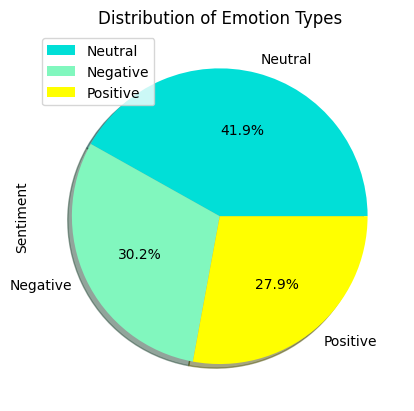

In [28]:
type_counts=train_data['Sentiment'].value_counts()
color=['#01DFD7', '#81F7BE','#FFFF00']
type_counts.plot(kind='pie',autopct='%1.1f%%', labels=type_counts.index,colors=color,shadow=True)
plt.title('Distribution of Emotion Types')
plt.legend()
plt.show()

In [29]:
train_data['Text'][0]

'I am coming to the borders and I will kill you all,'

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?://[^\s\n\r]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

train_data['Text']=train_data['Text'].apply(preprocess_text)
test_data['Text']=test_data['Text'].apply(preprocess_text)

In [ ]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
train_data['Text']=train_data['Text'].apply(simple_stemmer)
test_data['Text']=test_data['Text'].apply(simple_stemmer)

In [35]:
stop=set(stopwords.words('english'))
print(stop)

{'but', 'being', 'she', 'about', 'were', 'with', 'both', 'now', 'isn', 'the', 'hasn', "you'd", 'through', 'weren', "didn't", 'did', 'why', 'there', 'any', 'y', 'same', "it's", 'shouldn', 'how', 'out', 'be', 'mightn', 'has', 'o', 'each', 'you', 'ours', 'he', 'nor', 'own', "haven't", 'can', 'having', 'then', 'wasn', 'have', 'down', 'only', 'his', 'theirs', 've', "shan't", 'whom', 'hers', "mustn't", 'below', 'most', 'more', 'ain', 'between', "that'll", 'does', 'its', 's', 'until', 'my', 'yours', 'm', 'not', 'needn', "won't", 'don', 'up', 'those', "you'll", 'yourself', 'yourselves', "she's", 'because', 'was', 'should', "wouldn't", 'i', 'aren', 'couldn', 'who', 'these', 'than', 'which', 'ourselves', "should've", 'your', 'further', 'been', "shouldn't", "mightn't", 'themselves', 'myself', 'herself', 'very', 'that', "hadn't", "weren't", 'is', 'it', 'if', 'few', 'of', 'again', 'here', 'during', 'doesn', 'above', 'some', 'mustn', 'while', 'to', 'under', 'all', 'haven', "hasn't", 'or', 'do', 'thi

In [ ]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
train_data['Preprocessed_Text']=train_data['Text'].apply(remove_stopwords)
test_data['Preprocessed_Text']=test_data['Text'].apply(remove_stopwords)

In [37]:
train_data.tail()

,ID,Information,Sentiment,Text,Preprocessed_Text
74676,9200,Nvidia,Positive,just realiz that the window partit of my mac i...,realiz window partit mac like year behind nvid...
74677,9200,Nvidia,Positive,just realiz that my mac window partit is year ...,realiz mac window partit year behind nvidia dr...
74678,9200,Nvidia,Positive,just realiz the window partit of my mac is now...,realiz window partit mac year behind nvidia dr...
74679,9200,Nvidia,Positive,just realiz between the window partit of my ma...,realiz window partit mac like year behind nvid...
74680,9200,Nvidia,Positive,just like the window partit of my mac is like ...,like window partit mac like year behind driver...


In [38]:
test_data.head()

,ID,Information,Sentiment,Text,Preprocessed_Text
0,352,Amazon,Neutral,bbc new amazon boss jeff bezo reject claim com...,bbc new amazon boss jeff bezo reject claim com...
1,8312,Microsoft,Negative,microsoft whi do i pay for word when it functi...,microsoft whi pay word function poorli samsung...
2,4371,CS-GO,Negative,csgo matchmak is so full of closet hack it a t...,csgo matchmak full closet hack truli aw game
3,4433,Google,Neutral,now the presid is slap american in the face th...,presid slap american face realli commit unlaw ...
4,6273,FIFA,Negative,hi eahelp ive had madelein mccann in my cellar...,hi eahelp ive madelein mccann cellar past year...


In [39]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust the 'max_features' parameter based on your dataset

# Fit and transform the training data
tfidf_train_features = tfidf_vectorizer.fit_transform(train_data['Preprocessed_Text'])

# Transform the validation data using the same vectorizer
tfidf_test_features = tfidf_vectorizer.transform(test_data['Preprocessed_Text'])

# Display the shape of the TF-IDF features
print(f"TF-IDF Training Features Shape: {tfidf_train_features.shape}")
print(f"TF-IDF Validation Features Shape: {tfidf_test_features.shape}")


TF-IDF Training Features Shape: (73995, 10000)
TF-IDF Validation Features Shape: (999, 10000)


In [40]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the class labels in both training and validation datasets
train_labels_encoded= label_encoder.fit_transform(train_data['Sentiment'])
test_labels_encoded = label_encoder.transform(test_data['Sentiment'])

print(train_labels_encoded.shape)
print(test_labels_encoded.shape)


(73995,)
(999,)


In [41]:
unique_values = np.unique(train_labels_encoded)

print(unique_values)

unique_values = np.unique(test_labels_encoded)

print(unique_values)



[0 1 2]
[0 1 2]


In [42]:
print(label_encoder.inverse_transform(unique_values))

['Negative' 'Neutral' 'Positive']


In [43]:
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the classifier on the TF-IDF training features and encoded labels
xgb_classifier.fit(tfidf_train_features, train_labels_encoded)

# Predict the encoded labels for the TF-IDF validation features
test_predictions_xgb_encoded = xgb_classifier.predict(tfidf_test_features)

# Decode the predicted labels back to the original class labels
test_predictions_xgb = label_encoder.inverse_transform(test_predictions_xgb_encoded)


In [44]:
accuracy_xgb = accuracy_score(test_data['Sentiment'], test_predictions_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")

XGBoost Accuracy: 0.77


In [45]:
# Display additional classification metrics for XGBoost
print("XGBoost Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_predictions_xgb))

print("XGBoost Classification Report:")
print( classification_report(test_data['Sentiment'], test_predictions_xgb))

XGBoost Confusion Matrix:
[[194  62  10]
 [ 40 385  31]
 [ 13  77 187]]
XGBoost Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.73      0.76       266
     Neutral       0.73      0.84      0.79       456
    Positive       0.82      0.68      0.74       277

    accuracy                           0.77       999
   macro avg       0.78      0.75      0.76       999
weighted avg       0.77      0.77      0.77       999



In [46]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr.fit(tfidf_train_features, train_labels_encoded)

#Fitting the model for tfidf features
test_predictions_lr_encoded=lr.predict(tfidf_test_features)

test_predictions_lr = label_encoder.inverse_transform(test_predictions_lr_encoded)

In [47]:
accuracy_lr = accuracy_score(test_data['Sentiment'], test_predictions_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")

Logistic Regression Accuracy: 0.85


In [48]:
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_predictions_lr))

print("Logistic Regression Classification Report:")
print( classification_report(test_data['Sentiment'], test_predictions_lr))

Logistic Regression Confusion Matrix:
[[233  22  11]
 [ 43 392  21]
 [ 10  38 229]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.88      0.84       266
     Neutral       0.87      0.86      0.86       456
    Positive       0.88      0.83      0.85       277

    accuracy                           0.85       999
   macro avg       0.85      0.85      0.85       999
weighted avg       0.86      0.85      0.85       999



In [49]:
#training the model
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#Fitting the model for Bag of words
svm.fit(tfidf_train_features, train_labels_encoded)

#Fitting the model for tfidf features
test_predictions_svm_encoded=svm.predict(tfidf_test_features)

test_predictions_svm = label_encoder.inverse_transform(test_predictions_svm_encoded)

In [50]:
accuracy_svm= accuracy_score(test_data['Sentiment'], test_predictions_svm)
print(f"SGD Classifier Accuracy: {accuracy_svm:.2f}")

SGD Classifier Accuracy: 0.78


In [51]:
print("SGD Classifier Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_predictions_svm ))

print("SGD Classifier Classification Report:")
print( classification_report(test_data['Sentiment'], test_predictions_svm ))

SGD Classifier Confusion Matrix:
[[207  43  16]
 [ 54 371  31]
 [ 19  56 202]]
SGD Classifier Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.78      0.76       266
     Neutral       0.79      0.81      0.80       456
    Positive       0.81      0.73      0.77       277

    accuracy                           0.78       999
   macro avg       0.78      0.77      0.78       999
weighted avg       0.78      0.78      0.78       999



In [52]:
mnb=MultinomialNB()
#fitting the mnb for bag of words
mnb.fit(tfidf_train_features, train_labels_encoded)

#Fitting the model for tfidf features
test_predictions_mnb_encoded=mnb.predict(tfidf_test_features)
test_predictions_mnb = label_encoder.inverse_transform(test_predictions_mnb_encoded)

In [53]:
accuracy_mnb= accuracy_score(test_data['Sentiment'], test_predictions_mnb)
print(f"Multinomial NB Accuracy: {accuracy_mnb:.2f}")

Multinomial NB Accuracy: 0.80


In [54]:
print("Multinomial NB Confusion Matrix:")
print(confusion_matrix(test_data['Sentiment'], test_predictions_mnb))

print("Multinomial NB Classification Report:")
print( classification_report(test_data['Sentiment'], test_predictions_mnb))

Multinomial NB Confusion Matrix:
[[209  41  16]
 [ 53 376  27]
 [ 24  39 214]]
Multinomial NB Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.79      0.76       266
     Neutral       0.82      0.82      0.82       456
    Positive       0.83      0.77      0.80       277

    accuracy                           0.80       999
   macro avg       0.80      0.79      0.79       999
weighted avg       0.80      0.80      0.80       999



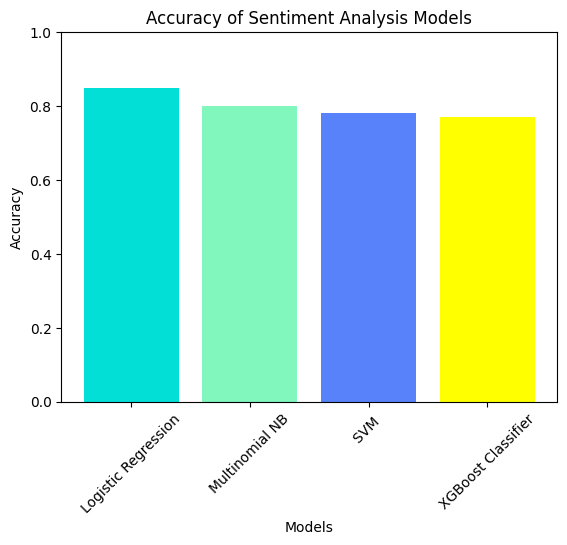

In [55]:
models = ['Logistic Regression','Multinomial NB','SVM ','XGBoost Classifier']
accuracies = [0.85,0.80, 0.78, 0.77]  # Replace with the actual accuracy values for each model

colors=['#01DFD7', '#81F7BE','#5882FA','#FFFF00']  # Specify a color for each bar

plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Sentiment Analysis Models')
plt.ylim(0, 1)  # Set the y-axis limits to 0 and 1 for accuracy percentage
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

In [56]:
train_reviews=train_data.Text

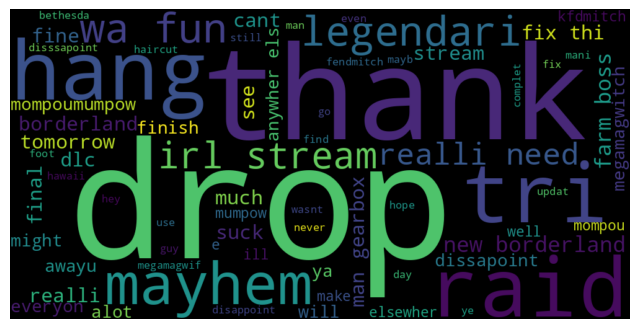

In [57]:
plt.figure(figsize=(8,8))
positive_text = " ".join(train_reviews[30:40])  # Combine the first two normalized training reviews into a single string

WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)

plt.imshow(positive_words, interpolation='bilinear')
plt.axis('off')  # Turn off axes and labels
plt.show()

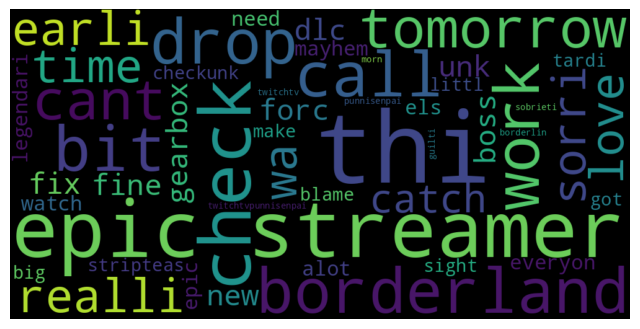

In [59]:
plt.figure(figsize=(8,8))
negative_text = " ".join(train_reviews[40:50])  # Combine the first two normalized training reviews into a single string

WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
negative_words = WC.generate(negative_text)

plt.imshow(negative_words, interpolation='bilinear')
plt.axis('off')  # Turn off axes and labels
plt.show()

# Sentiment Analysis with Deep Learning (LSTM)

In [60]:
# Loading data

df1= pd.read_csv('/content/twitter_training.csv')
df2= pd.read_csv('/content/twitter_validation.csv')

In [61]:
columns_to_drop = ['2401', 'Borderlands']
df1 = df1.drop(columns=columns_to_drop, errors='ignore')
columns_to_drop = ['3364', 'Facebook']
df2 = df2.drop(columns=columns_to_drop, errors='ignore')

In [62]:
# columns rename
columns_mapping = {
    'Positive': 'sentiment',
    'im getting on borderlands and i will murder you all ,': 'Comments'}

df1= df1.rename(columns= columns_mapping)

columns_mapping = {
    'Irrelevant': 'sentiment',
    'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'Comments'}

df2= df2.rename(columns= columns_mapping)

In [63]:
df = pd.concat([df1, df2],)
df

,sentiment,Comments
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [64]:
df['sentiment']= df['sentiment'].replace('Irrelevant','Neutral')
df['sentiment'].value_counts()

Neutral     31764
Negative    22808
Positive    21108
Name: sentiment, dtype: int64

In [65]:
df.dropna(subset= ['Comments'],inplace= True)
df.isnull().sum()

sentiment    0
Comments     0
dtype: int64

In [66]:
df= df.drop_duplicates()
df['sentiment'].value_counts()

Neutral     29578
Negative    21329
Positive    19270
Name: sentiment, dtype: int64

In [ ]:
def preprocess_text(text):
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F700-\U0001F77F"  # Alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric shapes
        "\U0001F800-\U0001F8FF"  # Miscellaneous Symbols and Arrows
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Extended-A
        "\U0001FA70-\U0001FAFF"  # Extended-B
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+"
    )
    text = emoji_pattern.sub(r'', text)

    # Remove other special characters (keep only alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    return text.strip()

# Apply the preprocessing function to the 'comment' column
df['Comments'] = df['Comments'].apply(preprocess_text)


# Display
df

In [68]:
df = df[df['Comments'].apply(lambda x: len(x.split()) <= 70)]

# Resetting the index after dropping rows
df.reset_index(drop=True, inplace=True)
df

,sentiment,Comments
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
70151,Neutral,Suikoden 2\n1 Alex Kidd in Miracle World\n Per...
70152,Positive,Thank you to Matching funds Home Depot RW paym...
70153,Neutral,Late night stream with the boys Come watch som...
70154,Neutral,Toronto is the arts and culture capital of Can...


In [69]:
tokenizer= Tokenizer()

Comments= df['Comments'].tolist()
tokenizer.fit_on_texts(Comments)

In [70]:
sequences= tokenizer.texts_to_sequences(Comments)
print('The max length in Comments is:',max([len(x) for x in sequences]))
print('The Unique word in the Comments are:',len(tokenizer.word_index))

The max length in Comments is: 70
The Unique word in the Comments are: 40758


In [71]:
# Padding
input_pad_sequences= pad_sequences(sequences,maxlen=70 ,padding= 'pre')

In [72]:
X= input_pad_sequences
y= df['sentiment']

In [73]:
# label encoder
le= LabelEncoder()
y= le.fit_transform(y)

y= to_categorical(y)

In [74]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56124, 70)
(14032, 70)
(56124, 3)
(14032, 3)


In [75]:
#build model
from keras.initializers import glorot_normal

model = Sequential()

model.add(Embedding(40758, 200, input_length=70, embeddings_initializer=glorot_normal()))

model.add(LSTM(100, return_sequences=True,dropout=0.6 ))


model.add(LSTM(100, return_sequences=True,dropout=0.6 ))

model.add(LSTM(100, return_sequences=True,dropout=0.6 ))


model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

In [76]:
# Compiling the model
model.compile(optimizer= 'adam',loss= 'categorical_crossentropy',metrics= ['accuracy'])

In [77]:
# Moodle Training
history = model.fit(X_train, y_train,epochs=10, batch_size=32,  validation_data=(X_test,y_test))

Epoch 1/10
1754/1754 [==============================] - 84s 40ms/step - loss: 0.7622 - accuracy: 0.6583 - val_loss: 0.5350 - val_accuracy: 0.7826
Epoch 2/10
1754/1754 [==============================] - 40s 23ms/step - loss: 0.4104 - accuracy: 0.8440 - val_loss: 0.3978 - val_accuracy: 0.8479
Epoch 3/10
1754/1754 [==============================] - 36s 21ms/step - loss: 0.2753 - accuracy: 0.8989 - val_loss: 0.3318 - val_accuracy: 0.8764
Epoch 4/10
1754/1754 [==============================] - 36s 21ms/step - loss: 0.2065 - accuracy: 0.9247 - val_loss: 0.2957 - val_accuracy: 0.8909
Epoch 5/10
1754/1754 [==============================] - 35s 20ms/step - loss: 0.1655 - accuracy: 0.9402 - val_loss: 0.2893 - val_accuracy: 0.9004
Epoch 6/10
1754/1754 [==============================] - 37s 21ms/step - loss: 0.1362 - accuracy: 0.9508 - val_loss: 0.2872 - val_accuracy: 0.9049
Epoch 7/10
1754/1754 [==============================] - 37s 21ms/step - loss: 0.1180 - accuracy: 0.9560 - val_loss: 0.3271 -

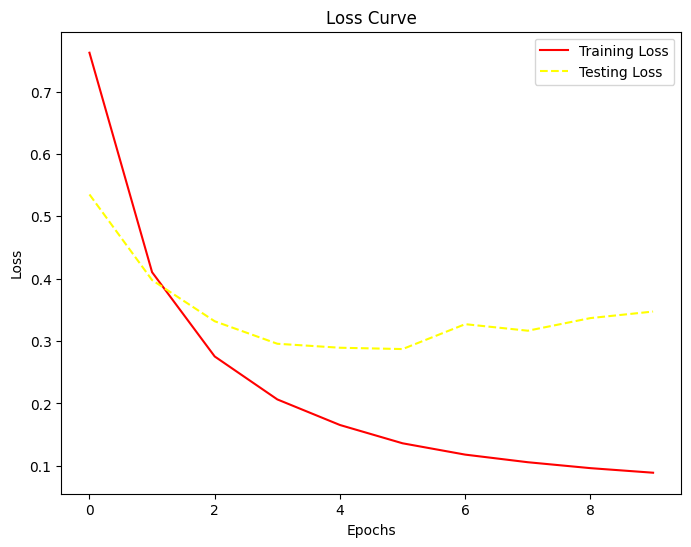

In [78]:
# Loss Curves

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'],ls='--',color='#FFFF00')
plt.legend(['Training Loss','Testing Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

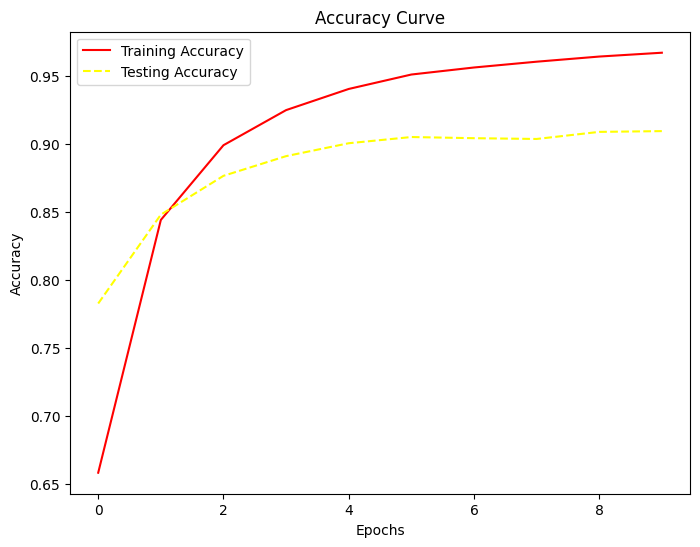

In [79]:
# Accuracy Curves

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],color='red')
plt.plot(history.history['val_accuracy'],ls='--',color='#FFFF00')
plt.legend(['Training Accuracy','Testing Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.show()



---
# NOTE ⚛

Comparison of Sentiment Analysis Models:

I have compared the performance of various sentiment analysis models, including the LSTM model and traditional machine learning models such as Logistic Regression, Multinomial NB, SVM, and XGBoost Classifier. Here is a summary of their accuracies:

- LSTM: The LSTM model achieved the highest accuracy of 91% in sentiment analysis. LSTM models excel in capturing contextual dependencies and are well-suited for sequence-based tasks. However, they may require more computational resources and longer training times.

- Logistic Regression: Logistic Regression achieved an accuracy of 85% in sentiment analysis. It is a simple and interpretable model that works well for linearly separable data. Logistic Regression can be a good choice when interpretability and computational efficiency are important.

- Multinomial NB: Multinomial Naive Bayes achieved an accuracy of 80% in sentiment analysis. It is a probabilistic model suitable for discrete feature data like word frequencies. Multinomial NB models are fast to train and can handle large feature spaces efficiently.

- SVM: Support Vector Machines achieved an accuracy of 78% in sentiment analysis. SVMs aim to find an optimal hyperplane to separate data points of different classes. They work well with high-dimensional feature spaces and can handle both linear and non-linear data. However, SVMs can be computationally expensive with large datasets.

- XGBoost Classifier: XGBoost Classifier achieved an accuracy of 77% in sentiment analysis. XGBoost is an ensemble learning method that combines multiple weak learners (decision trees) for predictions. It is known for its speed, scalability, and ability to handle diverse data types.

Overall, the LSTM model outperformed the traditional machine learning models in terms of accuracy, achieving 91%. However, when selecting the most suitable model for sentiment analysis, it is crucial to consider other factors such as interpretability, training time, computational resources, and specific task requirements.
